Objective: You are provided with a dataset containing customer details CustomerID, Age, Subscription, Churned (0/1). Your task is to analyze the data, perform necessary preprocessing, and build a machine learning model to predict customer churn. You will evaluate the model's performance using appropriate metrics and visualize key insights from the data.

**import all necessary libraries for Model**

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Flask,request,jsonify

**Customer Class with Expectection Handling**

In [96]:
class Customer:
    def __init__(self, name: str, age: int, churn_probability: float):
        if not isinstance(name, str):
            raise TypeError("Name must be a string.")
        if not isinstance(age, int):
            raise TypeError("Age must be an integer.")
        if not isinstance(churn_probability, float):
            raise TypeError("Churn probability must be a float.")
        
        if not (0 <= churn_probability <= 1):
            raise ValueError("Churn probability must be between 0 and 1.")

        self.name = name
        self.age = age
        self.churn_probability = churn_probability

    def is_high_risk(self, threshold: float = 0.7) -> bool:
        """Determine if the customer is high risk based on a threshold."""
        return self.churn_probability > threshold

    def _str_(self):
        risk_status = "High Risk" if self.is_high_risk() else "Low Risk"
        return f"Customer(name='{self.name}', age={self.age}, risk_status='{risk_status}')"
    

**Load and preprocess data**

In [59]:
def load_and_preprocess(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(r"C:\Users\Kunal Shinde.DESKTOP-G542VSS\OneDrive\Desktop\jupyter\customer_churn_dataset.csv")

    # Fill missing values
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Subscription'].fillna(df['Subscription'].mode()[0], inplace=True)

    # One-hot encoding for 'Subscription'
    df = pd.get_dummies(df, columns=['Subscription'], drop_first=True)

    return df

# Calculate average age of churned customers.
def calculate_avg_age_of_churned(df: pd.DataFrame) -> float:
    return df.loc[df['Churned'] == 1, 'Age'].mean()

**Data Visualization For Age**

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

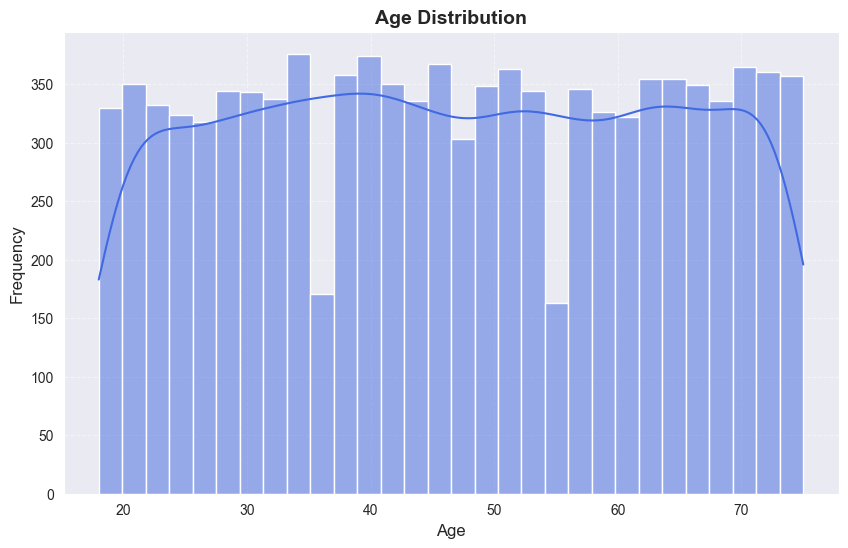

In [123]:
sns.set_style("darkgrid")
palette = "coolwarm"  # Choose an attractive color palette
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, color="royalblue", bins=30)
plt.title('Age Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

**Data Visualization For Cutomer Churned and Count**

C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Temp\ipykernel_11576\1194234897.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churned', data=df, palette="PiYG")


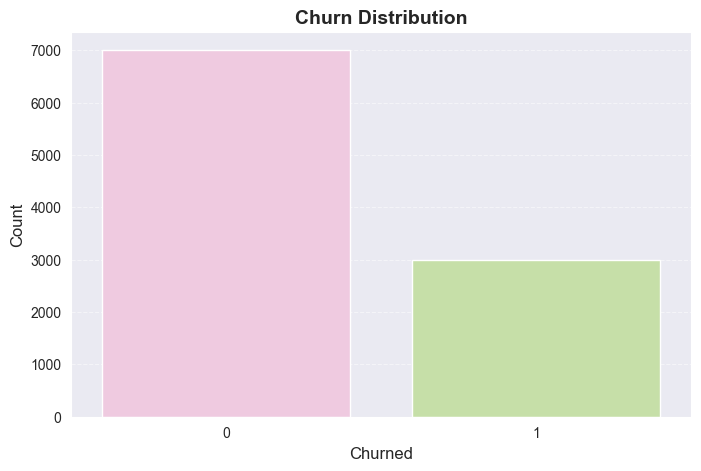

In [130]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Churned', data=df, palette="PiYG")
plt.title('Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churned', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()

**Data Visualization for Age Distribution by Churn Status**

C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Temp\ipykernel_11576\2782924267.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churned', y='Age', data=df, palette='colorblind')


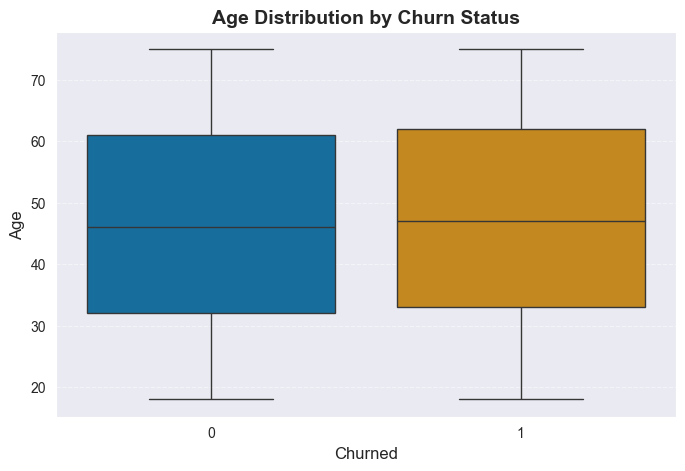

In [127]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churned', y='Age', data=df, palette='colorblind')
plt.title('Age Distribution by Churn Status', fontsize=14, fontweight='bold')
plt.xlabel('Churned', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()

**Regular Expressions & Text Processing**

In [115]:
nltk.download('stopwords') 
# Extract emails using a compiled regex.
email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')

def extract_emails(text: str) -> list:
    return email_pattern.findall(text)

# stopword removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text: str) -> str:
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

file_path = '/mnt/data/customer_churn_dataset (1).csv'
df = load_and_preprocess(file_path)

avg_age_churned = calculate_avg_age_of_churned(df)
print(f"Average age of churned customers: {avg_age_churned}")

Average age of churned customers: 46.981320880587056


[nltk_data] Downloading package stopwords to C:\Users\Kunal
[nltk_data]     Shinde.DESKTOP-G542VSS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Temp\ipykernel_11576\602135461.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Temp\ipykernel_11576\602135461.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Serie

**Model Training & Evaluation**

In [61]:
# Prepare data
X = df.drop(['CustomerID', 'Churned'], axis=1)
y = df['Churned']

# pipeline for scaling and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83      1430
           1       0.00      0.00      0.00       570

    accuracy                           0.71      2000
   macro avg       0.36      0.50      0.42      2000
weighted avg       0.51      0.71      0.60      2000

Accuracy Score: 0.715


C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kunal Shinde.DESKTOP-G542VSS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

**Confusion Matrix Visualization**

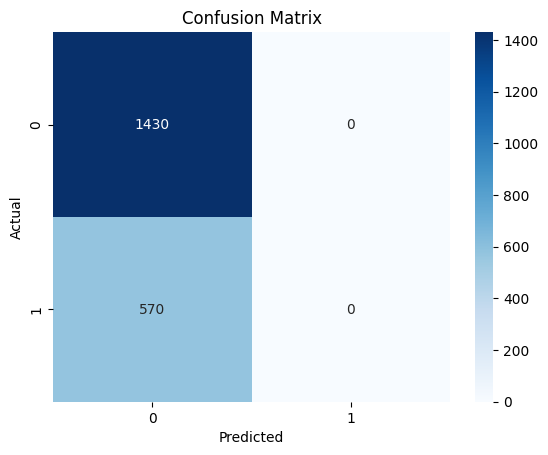

In [69]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Cross-validation scores**

In [63]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean():.4f}")

Cross-validation Accuracy Scores: [0.7005 0.7005 0.7    0.7    0.7   ]
Mean Cross-validation Accuracy: 0.7002


**Feature importance (using model coefficients)**

In [64]:
features = X.columns
importance = pipeline.named_steps['model'].coef_[0]
feature_importance = pd.Series(importance, index=features).sort_values(ascending=False)
print("\nFeature Importance:\n", feature_importance)


Feature Importance:
 Age                      0.002435
Subscription_Standard   -0.019491
Subscription_Premium    -0.042172
dtype: float64


**Trying to Improve Accuarcy By using Hyperparameter tuning for Random Forest**

In [76]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print(classification_report(y_test, y_pred_rf))

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      1430
           1       0.31      0.01      0.01       570

    accuracy                           0.71      2000
   macro avg       0.51      0.50      0.42      2000
weighted avg       0.60      0.71      0.60      2000



**Save Model in Pickle**

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 

# Save the scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

with open('logistic_model.pkl', 'wb') as model_file:
    pickle.dump(best_lr_model, model_file)

with open('random_forest_model.pkl', 'wb') as rf_file:
    pickle.dump(best_rf_model, rf_file)


**Flask API for prediction**

In [5]:
from flask import Flask, request, jsonify
from pydantic import BaseModel, ValidationError
import traceback

In [6]:
from flask import Flask, request, jsonify
from pydantic import BaseModel, ValidationError
import traceback

app = Flask(__name__)
scaler = StandardScaler()
class CustomerData(BaseModel):
    Age: float
    Subscription_Yes: int = 0

@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({'status': 'API is running'}), 200

# Prediction Endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # incoming JSON data
        data = CustomerData(**request.get_json())

        # Prepare input for prediction
        input_data = np.array([[data.Age, data.Subscription_Yes]])
        input_scaled = scaler.transform(input_data)

        # Generate prediction
        prediction = best_rf_model.predict(input_scaled)
        return jsonify({'churn_prediction': int(prediction[0])}), 200

    except ValidationError as ve:
        return jsonify({'error': ve.errors()}), 400
    except Exception as e:
        return jsonify({'error': str(e), 'trace': traceback.format_exc()}), 500

# Main Execution
if __name__ == '_main_':
    app.run(debug=True, host='0.0.0.0', port=5000)